In [1]:
import os
import numpy as np
import pandas as pd
from datetime import timedelta
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

In [ ]:
#https://www.kaggle.com/code/pawelkauf/etf-data-preprocessing-for-multi-year-analysis

In [2]:
for dirname, _, filenames in os.walk('C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\a.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aa.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aaap.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aaba.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aac.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aal.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aamc.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aame.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aan.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aaoi.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aaon.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aap.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aapl.us.txt
C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks\aat.us.txt
C:

In [3]:
def read_data_files(data_dir):
    data_frames = {}
    original_row_counts = {}
    last_dates = {}
    empty_files = []
    
    print(f"Reading data from {data_dir}...")
    for dirname, _, filenames in os.walk(data_dir):
        for filename in tqdm(filenames):
            if filename.endswith('.txt'):
                file_path = os.path.join(dirname,filename)
                try:
                    df=pd.read_csv(file_path)
                    
                    if df.empty:
                        #print(f"lenght is {len(df)} \ndataframes ############ \n {df.head(2)}")
                        empty_files.append(file_path)
                        continue
                    
                    df['Date'] = pd.to_datetime(df['Date'])
                    key = filename.split('.')[0]
                    data_frames[key]=df
                    original_row_counts[key] = df
                    last_dates[key] = df['Date'].max()
                    #print(f"key is ***{key}****")
                    #print(f"lenght is {len(df)} \ndataframe keys ************ \n {data_frames[key].head(3)}")
                except pd.errors.EmptyDataError:
                    empty_files.append(file_path)
    return data_frames, original_row_counts, last_dates, empty_files

In [4]:
#data_dir = 'C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks'
#dfs,row_cnts,lst_dts,empty_files = read_data_files(data_dir)

In [5]:
#dfs['aac']

In [6]:
#cmn_lst_date = min(lst_dts)
#print(f"keys in dataframe {dfs.keys()}")
#for symbol, df in dfs.items():
 #   print(f"symbol {symbol}")
  #  print(df.head(1))

In [7]:
def trim_data_to_common_last_date(data_frames,last_dates):
    common_last_date = min(last_dates.values())
    trimmed_data_frames = {symbol: df[df['Date']<=common_last_date] for symbol, df in data_frames.items()}
    return trimmed_data_frames, common_last_date
def find_closest_date(df,target_date):
    dates = df['Date']
    closest_date = dates[dates <= target_date].max()
    return closest_date

In [10]:
#trim_dfs,cmn_lst_dts=trim_data_to_common_last_date(dfs,lst_dts)

In [11]:
def calculate_proportions(data_frames, common_last_date, max_months=156):
    proportions = {}
    dataset_counts = {}
    for months in range(1, max_months+1):
        start_date = common_last_date - timedelta(days=months*30)
        #print(common_last_date, start_date)
        count = sum(1 for df in data_frames.values() if not df[(df['Date']<=start_date)&(df['Date']<=common_last_date)].empty)
        proportions[months] = count / len(data_frames)
        dataset_counts[months]=count
        
    return proportions, dataset_counts

In [12]:
#props,dts_cnts = calculate_proportions(dfs,cmn_lst_dts)
#len(props)

In [13]:
def save_trimmed_data_frames(data_frames, output_dir):
    print(f"Saving trimmed Dataframes to {output_dir}...")
    os.makedirs(output_dir,exist_ok=True)
    for symbol, df in tqdm(data_frames.items()):
        df.to_csv(os.path.join(output_dir,f'{symbol}_trimmed.csv'),index=False)

In [14]:
def save_data_by_year(data_frames,common_last_date, output_base_dir, max_years=13):
    print(f"Saving trimmed Dataframes to {output_base_dir}...")
    for year in tqdm(range(1, max_years+1)):
        start_date = common_last_date - timedelta(days=year*365)
        year_dir = os.path.join(output_base_dir,f'Year_{year}')
        os.makedirs(year_dir, exist_ok=True)
        for symbol, df in data_frames.items():
            closest_start_date = find_closest_date(df, start_date)
            trimmed_df = df[(df['Date'] >=closest_start_date)&(df['Date']<=common_last_date)]
            if not trimmed_df.empty and len(trimmed_df)>=year*365//7:
                trimmed_df.to_csv(os.path.join(year_dir,f'{symbol}_trimmed.csv'),index=False)
        

In [15]:
def plot_proportions(proportions, dataset_counts):
    months = list(proportions.keys())
    values = list(proportions.values())
    counts = list(dataset_counts.values())
    
    plt.figure(figsize=(14,8))
    plt.plot(months, values, marker='o', linestyle='-',color='b', label='Proportions of Datasets')
    
    for year in range(1, len(proportions)//12+1):
        x = year*12
        y = proportions[x]
        count = dataset_counts[x]
        plt.axvline(x=x, color='gray',linestyle='--',alpha=0.7)
        plt.text(x,y,f'Year {year}\n{y:.2f}', ha='center',va='bottom', color='red',fontsize=10,fontweight='bold',bbox=dict(facecolor='white',alpha=0.5))
        plt.text(x,y-0.05,f'Count: {count}',ha='center',va='top',color='green',fontsize=10, fontweight='bold')
        
    plt.xlabel('Months',fontsize=14)
    plt.ylabel('Proportion of Datasets', fontsize=14)
    plt.title('Proportion of Datasets Meeting the Month Range Requirments',fontsize=13)
    plt.legend()
    plt.grid(True, linestyle='--',alpha=0.7)
    plt.xticks(ticks=[12*i for i in range(len(proportions)//12+1)],
               labels=[f'Year {i}' for i in range(len(proportions)//12+1)])

    plt.tight_layout()
    plt.show()
        

In [16]:
def process_data(data_dir, output_base_dir, max_months=156):
    data_frames, original_row_counts, last_dates, empty_files = read_data_files(data_dir)
    
    trimmed_data_frames, common_last_date = trim_data_to_common_last_date(data_frames, last_dates)
    save_trimmed_data_frames(trimmed_data_frames,os.path.join(output_base_dir, 'trimmed'))
    save_data_by_year(trimmed_data_frames,common_last_date,output_base_dir, max_years=max_months//12)
    
    proportions, dataset_counts = calculate_proportions(trimmed_data_frames, common_last_date, max_months)
    
    plot_proportions(proportions, dataset_counts)
    
    print("\nStatistics")
    print(f'\nTotal Files read: {len(data_frames)+len(empty_files)}')
    print(f'\nFiles read: {len(data_frames)}')
    print(f'\nEmpty files: {len(empty_files)}')
    print(f'\nCommon last available date: {common_last_date}\n\n*******---*******')
    

Reading data from C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/ETFs...


100%|██████████| 1344/1344 [00:14<00:00, 90.38it/s] 


Saving trimmed Dataframes to C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/ETFs_final\trimmed...


100%|██████████| 1344/1344 [00:12<00:00, 109.55it/s]


Saving trimmed Dataframes to C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/ETFs_final...


100%|██████████| 13/13 [01:12<00:00,  5.56s/it]


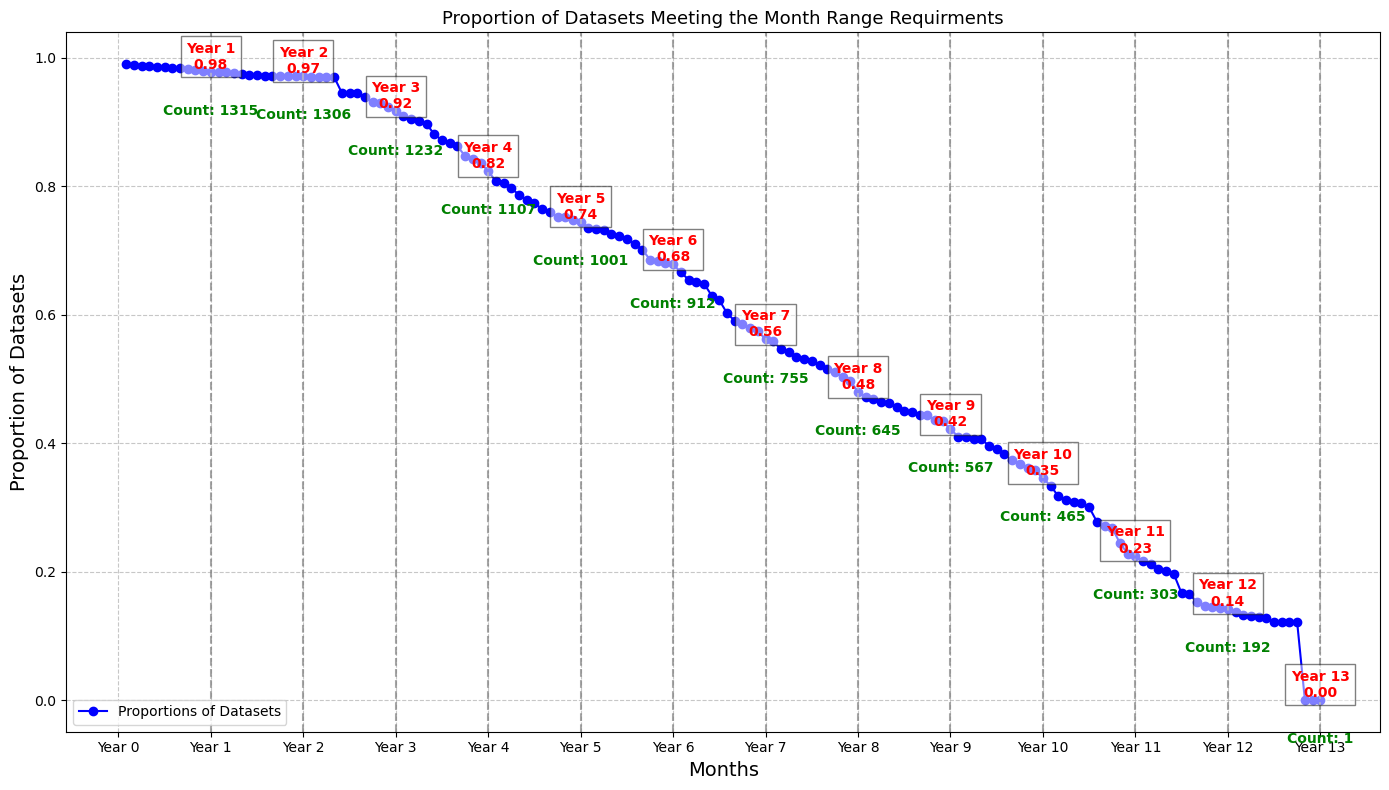


Statistics

Total Files read: 1344

Files read: 1344

Empty files: 0

Common last available date: 2017-10-04 00:00:00

*******---*******
Reading data from C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks...


100%|██████████| 7195/7195 [00:45<00:00, 158.51it/s]


Saving trimmed Dataframes to C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks_final\trimmed...


100%|██████████| 7163/7163 [01:09<00:00, 102.97it/s]


Saving trimmed Dataframes to C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks_final...


100%|██████████| 13/13 [07:06<00:00, 32.81s/it]


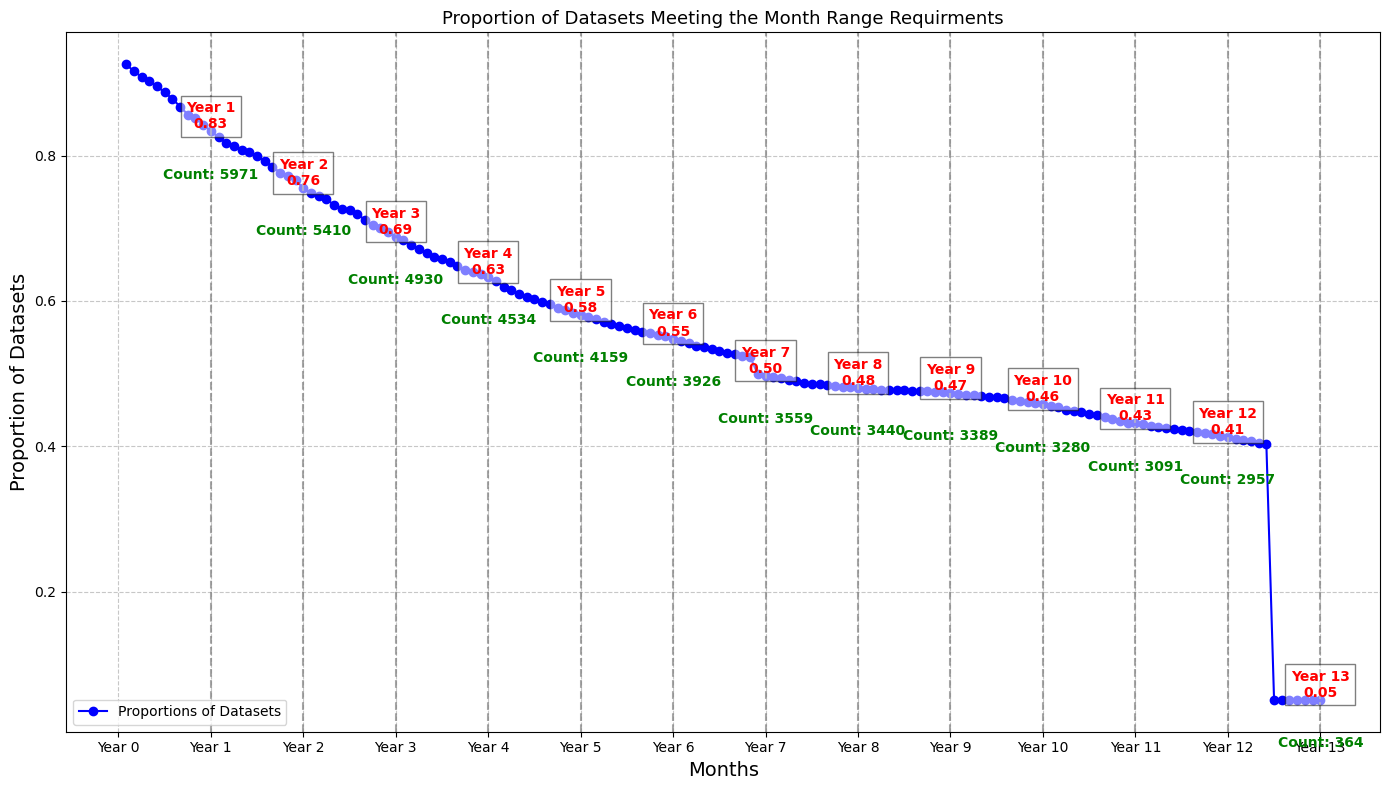


Statistics

Total Files read: 7195

Files read: 7163

Empty files: 32

Common last available date: 2017-06-07 00:00:00

*******---*******


In [39]:
def main():
    etf_data_dir = 'C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/ETFs'
    stock_data_dir = 'C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks'
    
    process_data(etf_data_dir, 'C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/ETFs_final')
    process_data(stock_data_dir, 'C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/Stocks_final')
    
if __name__ == '__main__':
    main()

### Data Preprocessing

In [179]:
import os
import glob
import pandas as pd
from tqdm import tqdm

In [180]:
trimmed_csv_files = glob.glob("C:/Users/sasid/Documents/QRA/Finance/StkPrcPred/Data/ETFs_final/trimmed/*.csv")

In [181]:
concat_df = pd.DataFrame()

In [182]:
#https://saturncloud.io/blog/how-to-read-multiple-csv-files-into-python-pandas-dataframe/#:~:text=We%20use%20the%20glob%20function,the%20read_csv%20function%20from%20Pandas.

In [183]:
for csv_file in tqdm(trimmed_csv_files):
    df = pd.read_csv(csv_file)
    filename =os.path.splitext( os.path.basename(csv_file))[0]
    filename = filename.split('_')[0]
    df['File'] = filename
    concat_df = pd.concat([concat_df,df])

100%|██████████| 1344/1344 [02:12<00:00, 10.14it/s]


In [184]:
print(len(concat_df))
concat_df.head()

2531473


,Date,Open,High,Low,Close,Volume,OpenInt,File
0,2010-07-21,24.333,24.333,23.946,23.946,43321,0,aadr
1,2010-07-22,24.644,24.644,24.362,24.487,18031,0,aadr
2,2010-07-23,24.759,24.759,24.314,24.507,8897,0,aadr
3,2010-07-26,24.624,24.624,24.449,24.595,19443,0,aadr
4,2010-07-27,24.477,24.517,24.431,24.517,8456,0,aadr


In [185]:
#finding null values
concat_df.isna().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
File       0
dtype: int64

In [186]:
#finding unique elements in dataframe
u=df['OpenInt'].unique()
print(u)

[0]


In [187]:
concat_df = concat_df.drop('OpenInt',axis=1)
concat_df.head(6)

,Date,Open,High,Low,Close,Volume,File
0,2010-07-21,24.333,24.333,23.946,23.946,43321,aadr
1,2010-07-22,24.644,24.644,24.362,24.487,18031,aadr
2,2010-07-23,24.759,24.759,24.314,24.507,8897,aadr
3,2010-07-26,24.624,24.624,24.449,24.595,19443,aadr
4,2010-07-27,24.477,24.517,24.431,24.517,8456,aadr
5,2010-07-28,24.477,24.517,24.352,24.431,4967,aadr


In [188]:
concat_df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume     object
File       object
dtype: object

In [189]:
concat_df['Date']=pd.to_datetime(df['Date'])
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2531473 entries, 0 to 2223
Data columns (total 7 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   Open    float64       
 2   High    float64       
 3   Low     float64       
 4   Close   float64       
 5   Volume  object        
 6   File    object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 154.5+ MB


In [190]:
concat_df = concat_df.sort_values(by='Date')

In [191]:
concat_df

,Date,Open,High,Low,Close,Volume,File
0,2008-12-03,24.333,24.333,23.946,23.946,43321,aadr
0,2008-12-03,42.044,42.049,42.044,42.049,553,nyf
0,2008-12-03,16108.000,16288.000,15804.000,15848.000,248,nugt
0,2008-12-03,12.192,12.192,12.066,12.066,39569,norw
0,2008-12-03,38.058,38.058,38.058,38.058,62002,nobl
...,...,...,...,...,...,...,...
2224,NaT,74.340,74.500,74.000,74.120,16346,ycs
2225,NaT,74.060,74.450,74.050,74.210,11816,ycs
2226,NaT,74.380,74.730,74.300,74.520,33357,ycs
2227,NaT,74.850,74.850,74.540,74.740,8420,ycs


In [192]:
len(concat_df['Date'].unique())

2225

In [193]:
concat_df[concat_df['Date'].isna()]

,Date,Open,High,Low,Close,Volume,File
2224,NaT,67.40,67.56,67.280,67.39,2022957,aaxj
2225,NaT,67.67,67.89,67.600,67.67,3447843,aaxj
2226,NaT,67.70,67.93,67.630,67.82,240162,aaxj
2227,NaT,68.48,68.61,68.225,68.41,255154,aaxj
2228,NaT,68.09,68.19,67.730,67.73,654842,aaxj
...,...,...,...,...,...,...,...
2224,NaT,74.34,74.50,74.000,74.12,16346,ycs
2225,NaT,74.06,74.45,74.050,74.21,11816,ycs
2226,NaT,74.38,74.73,74.300,74.52,33357,ycs
2227,NaT,74.85,74.85,74.540,74.74,8420,ycs


In [194]:
concat_df.dropna(subset=['Date'], inplace=True)

In [195]:
concat_df[concat_df['Date'].isna()]

,Date,Open,High,Low,Close,Volume,File


In [196]:
len(concat_df)

2220851

In [197]:
print(f'Zeros in Open {concat_df.Open[concat_df.Open==0].count()}')
print(f'Zeros in Close {concat_df.Close[concat_df.Close==0].count()}')
print(f'Zeros in High {concat_df.High[concat_df.High==0].count()}')
print(f'Zeros in Low {concat_df.Low[concat_df.Low==0].count()}')

Zeros in Open 19
Zeros in Close 0
Zeros in High 0
Zeros in Low 26


In [198]:
concat_df = concat_df[(concat_df != 0).all(1)]
#Droping rows with atleast 1 Zero 
#https://stackoverflow.com/questions/74808517/remove-rows-where-at-least-one-zero-value

In [199]:
print(f'Zeros in Open {concat_df.Open[concat_df.Open==0.0].count()}')
print(f'Zeros in Close {concat_df.Close[concat_df.Close==0.0].count()}')
print(f'Zeros in High {concat_df.High[concat_df.High==0.0].count()}')
print(f'Zeros in Low {concat_df.Low[concat_df.Low==0.0].count()}')

Zeros in Open 0
Zeros in Close 0
Zeros in High 0
Zeros in Low 0


In [200]:
len(concat_df)

2217837

In [201]:
concat_df['Date'].iloc[-11:]

2223   2017-10-04
2223   2017-10-04
2223   2017-10-04
2223   2017-10-04
2223   2017-10-04
2223   2017-10-04
2223   2017-10-04
2223   2017-10-04
2223   2017-10-04
2223   2017-10-04
2223   2017-10-04
Name: Date, dtype: datetime64[ns]

In [202]:
concat_df

,Date,Open,High,Low,Close,Volume,File
0,2008-12-03,24.333,24.333,23.946,23.946,43321,aadr
0,2008-12-03,42.044,42.049,42.044,42.049,553,nyf
0,2008-12-03,16108.000,16288.000,15804.000,15848.000,248,nugt
0,2008-12-03,12.192,12.192,12.066,12.066,39569,norw
0,2008-12-03,38.058,38.058,38.058,38.058,62002,nobl
...,...,...,...,...,...,...,...
2223,2017-10-04,87.505,87.647,87.221,87.505,138178,voe
2223,2017-10-04,40.761,41.086,40.761,41.001,27038,iai
2223,2017-10-04,47.190,47.477,47.066,47.393,40911,iak
2223,2017-10-04,106.030,106.320,106.030,106.200,107738,gvi


In [203]:
#performing substraction on columns is notworking on concat_df
concaterd = concat_df.copy()
concaterd

,Date,Open,High,Low,Close,Volume,File
0,2008-12-03,24.333,24.333,23.946,23.946,43321,aadr
0,2008-12-03,42.044,42.049,42.044,42.049,553,nyf
0,2008-12-03,16108.000,16288.000,15804.000,15848.000,248,nugt
0,2008-12-03,12.192,12.192,12.066,12.066,39569,norw
0,2008-12-03,38.058,38.058,38.058,38.058,62002,nobl
...,...,...,...,...,...,...,...
2223,2017-10-04,87.505,87.647,87.221,87.505,138178,voe
2223,2017-10-04,40.761,41.086,40.761,41.001,27038,iai
2223,2017-10-04,47.190,47.477,47.066,47.393,40911,iak
2223,2017-10-04,106.030,106.320,106.030,106.200,107738,gvi


In [204]:
concaterd['Changes'] = concaterd['Close']-concaterd['Open']

In [206]:
concaterd

,Date,Open,High,Low,Close,Volume,File,Changes
0,2008-12-03,24.333,24.333,23.946,23.946,43321,aadr,-0.387
0,2008-12-03,42.044,42.049,42.044,42.049,553,nyf,0.005
0,2008-12-03,16108.000,16288.000,15804.000,15848.000,248,nugt,-260.000
0,2008-12-03,12.192,12.192,12.066,12.066,39569,norw,-0.126
0,2008-12-03,38.058,38.058,38.058,38.058,62002,nobl,0.000
...,...,...,...,...,...,...,...,...
2223,2017-10-04,87.505,87.647,87.221,87.505,138178,voe,0.000
2223,2017-10-04,40.761,41.086,40.761,41.001,27038,iai,0.240
2223,2017-10-04,47.190,47.477,47.066,47.393,40911,iak,0.203
2223,2017-10-04,106.030,106.320,106.030,106.200,107738,gvi,0.170


In [208]:
import matplotlib.pyplot as plt

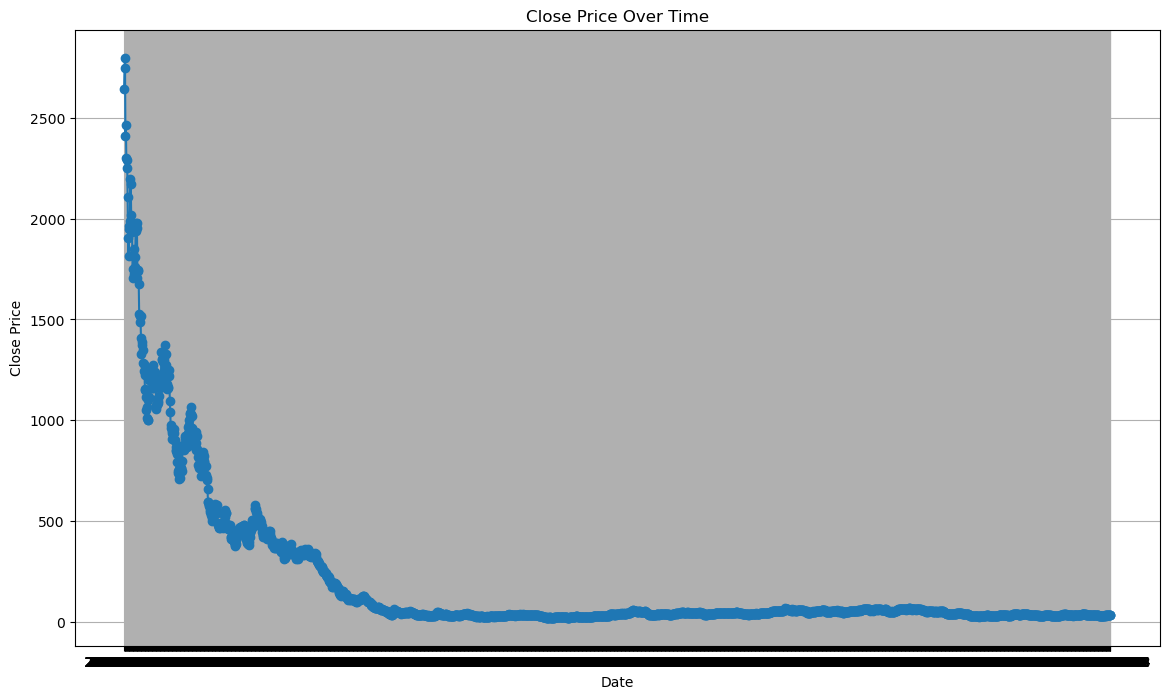

In [209]:
plt.figure(figsize=(14,8))
plt.plot(df['Date'],df['Close'],marker='o')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()